**Try inpainting on video yourself**

In [1]:
#@title Run this sell to set everything up
print('\n> Cloning the repo')
!git clone https://github.com/advimman/lama.git

print('\n> Install dependencies')
!pip install torch==1.8.0 torchvision==0.9.0 torchaudio==0.8.0 torchtext==0.9
!pip install -r lama/requirements.txt --quiet
!pip install wget --quiet
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html --quiet


print('\n> Changing the dir to:')
%cd /content/lama

print('\n> Download the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

print('>fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-contrib-python-headless==4.4.0.46 --quiet
#!pip install opencv-contrib-python-headless==4.1.2.30


print('\n> Init mask-drawing code')
import base64, os
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
import numpy as np
import wget
from shutil import copyfile
import shutil
import cv2 as cv


canvas_html = """
<style>
.button {
  background-color: #4CAF50;
  border: none;
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  margin: 4px 2px;
  cursor: pointer;
}
</style>
<canvas1 width=%d height=%d>
</canvas1>
<canvas width=%d height=%d>
</canvas>

<button class="button">Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')


ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


> Cloning the repo
Cloning into 'lama'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 399 (delta 76), reused 68 (delta 55), pack-reused 271
Receiving objects: 100% (399/399), 9.87 MiB | 15.06 MiB/s, done.
Resolving deltas: 100% (138/138), done.

> Install dependencies
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 55.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 58.7 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
  

In [2]:
# print the mask and mask*image
def show_image(frame1, mask):
  plt.figure(figsize=(18,6))
  plt.subplot(131)
  plt.imshow(mask, cmap='gray')
  plt.axis('off')
  plt.title('mask')
  
  plt.subplot(132)
  img = np.array(plt.imread(frame1)[:,:,:3])    # image is defined
  plt.imshow(img)
  plt.axis('off')
  plt.title('img')

  plt.subplot(133)
  img = np.array((1-mask.reshape(mask.shape[0], mask.shape[1], -1))*plt.imread(frame1)[:,:,:3])  # image with mask is defined
  _=plt.imshow(img)
  _=plt.axis('off')
  _=plt.title('img * mask')
  plt.show()

In [3]:
def run_impainting():
  print('Run inpainting')
  !PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$(pwd)/big-lama indir=$(pwd)/data_image outdir=/content/output  dataset.img_suffix=.png > /dev/null


Predefined video : uncomment any line,
Local file: leave the vname = None

In [14]:
shutil.rmtree('./data_for_prediction', ignore_errors=True)   # remove any previously present folder/directory
!mkdir data_for_prediction     # creating the folder/directory

vname = None
vname = 'colab/B-1B Lancer Heavy Bombers at Aero India 2023.mp4' # <-in the example 
shutil.copy(vname, './data_for_prediction/B-1B Lancer Heavy Bombers at Aero India 2023.mp4')
vanme = f'./data_for_prediction/B-1B Lancer Heavy Bombers at Aero India 2023.mp4'

# un-comment the below lines for uploading the video
# if vname is None:
#   from google.colab import files
#   files = files.upload()   # create option to upload the file
#   vname = list(files.keys())[0] # saves the file in 'vname'


# #coping the video file in directory 'data_for_prediction'

#copyfile(vname, f'./data_for_prediction/{vname}')   # copying the file in the created folder
#os.remove(vname)    # removing the instance of the file from 'fname'
#vname = f'./data_for_prediction/{vname}'   # reading the file form the folder

In [15]:
# video details 
def video_fps():
    video = cv.VideoCapture(vname);
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv.__version__).split('.')
 
    fps = video.get(cv.CAP_PROP_FPS)
    return fps

    video.release()

def frame_size():
  vcap = cv.VideoCapture(vname) 
 
  if vcap.isOpened(): 
    # get vcap property 
    width  = int(vcap.get(3))   # float `width`
    height = int(vcap.get(4))  # float `height`

  return [width, height]

Draw a Mask, Press Finish, Wait for Inpainting

Will use /content/lama/frame1.png for inpainting


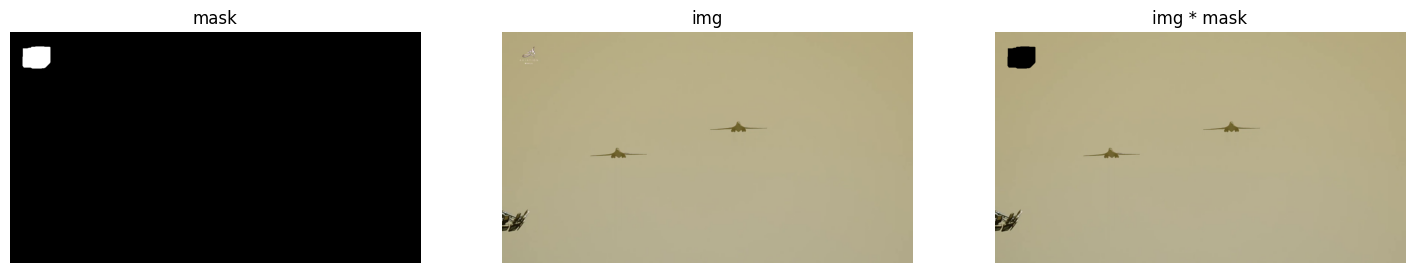

Run inpainting
100% 796/796 [08:04<00:00,  1.64it/s]
Impainting completed
combining frames to make video
Video formation done


In [16]:
shutil.rmtree('/content/lama/data_image', ignore_errors=True)   # remove any previously present folder/directory
!mkdir data_image     # creating the folder/directory
i = 0
cap1 = cv.VideoCapture(vname) # path of the first inferenced video

while True:
    ret1, frame1 = cap1.read()  # reading the video 1
    
    if not ret1:   # break for last frame.
      break

    # push the first frame to draw function
    if (i==0):
      i = i+1
      plt.imsave("frame1.png",frame1)  # save the mask in the directory

      frame = '/content/lama/frame1.png'

      image64 = base64.b64encode(open(frame, 'rb').read())  # converting the file into string of base 64 format
      image64 = image64.decode('utf-8')  # decoding from string format to utf-8 format
    
      print(f'Will use {frame} for inpainting')
      img = np.array(plt.imread(frame)[:,:,:3])  # reading the image from the folder, converting it into numpy array format.
    
      draw(image64, filename="frame1_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.04*img.shape[1])
    
      with_mask = np.array(plt.imread(f"frame1_mask.png")[:,:,:3])
      mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)   # mask is defined
    
      plt.imsave("frame1_mask.png",mask, cmap='gray')  # save the mask in the directory
      
      show_image(frame, mask)  # displating mask, image , image*mask
    
    # saving images and masks for runing impainting
    plt.imsave(f"./data_image/frame{i}.png",frame1)
    mask = plt.imread('/content/lama/frame1_mask.png')
    plt.imsave(f"./data_image/frame{i}_mask.png", mask, cmap='gray')
    i = i+1
    
cap1.release()
run_impainting()
print ('Impainting completed')

# make video form the images
print ('combining frames to make video')
out = cv.VideoWriter('Output_video_su30mki.avi', cv.VideoWriter_fourcc(*'MJPG'), video_fps(), (frame_size()[0], frame_size()[1])) 
                    # put output video name
for i in range(1, len(os.listdir('/content/output/'))):
    img = cv.imread(f'/content/output/frame{i}_mask.png') 
    out.write(img)
out.release()
shutil.rmtree('/content/lama/data_image', ignore_errors=True) 
shutil.rmtree('/content/output', ignore_errors=True)
print ('Video formation done')

vname = None